# Segundo Trabalho Prático de Introdução à Computação Visual (ICV) na UFMG:

Artur Gaspar da Silva

Link do vídeo: https://youtu.be/o_ckpaJes4k

Pequenas observações:
    
- Em cada célula de código que tem um cv2.imshow(), eu também coloquei a imagem manualmente para ter a imagem independentemente da execução. Então cada imagem aparecerá duas vezes depois que o notebook for rodado.
- Esse notebook deve ser executado em ordem. Algumas células de código mostram uma janela com uma imagem. ***NÃO CLIQUE NO "X" VERMELHO PRA FECHAR AS JANELAS DE IMAGEM!*** Pra fechar a janela, digite qualquer tecla. Se por engano clicar no "x" vermelho, será preciso reiniciar o Kernel do notebook.
- A célula final renderiza e mostra numa janela, como no código esqueleto, o vídeo resultante. Por causa disso, esse notebook *não* funciona no google colab. É preciso rodar localmente, já tendo as bibliotecas instaladas.
- Pra fechar a janela do vídeo renderizado, é preciso clicar no "X" vermelho.

### Baixando video, modelo, alvo e objloader

In [ ]:
!wget --no-check-certificate https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/entrada.mp4
!wget --no-check-certificate https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/pikach_obj.zip
!wget --no-check-certificate https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/alvo.jpg
!wget --no-check-certificate https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/objloader.py
!unzip pikach_obj.zip

### Importando bibliotecas a serem usadas:

In [ ]:
import pygame
import cv2
from cv2 import threshold
import numpy as np

from OpenGL.GL import *
from OpenGL.GLUT import *
from OpenGL.GLU import *

from PIL import Image
from PIL import ImageOps

from objloader import *

## Parte 1: Calibrando a câmera

Antes de tudo, precisamos realizar o processo de calibrar a câmera, ou seja, obter seus parâmetros intrínsecos (foco, centro óptico, distorções e etc.)

Para fazer isso, utilizamos o toolbox de Jean-Yves Bouguet para Octave. Os frames utilizados para calibração foram os seguintes:

<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/calibs/0.jpg" alt="Drawing" style="width: 200px;"/>
<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/calibs/1.jpg" alt="Drawing" style="width: 200px;"/>
<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/calibs/2.jpg" alt="Drawing" style="width: 200px;"/>
<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/calibs/3.jpg" alt="Drawing" style="width: 200px;"/>
<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/calibs/4.jpg" alt="Drawing" style="width: 200px;"/>
<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/calibs/5.jpg" alt="Drawing" style="width: 200px;"/>
<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/calibs/6.jpg" alt="Drawing" style="width: 200px;"/>

Depois de selecionar as quinas dos tabuleiros de xadrez e utilizar o Toolkit, obtemos os seguintes resultados:
```
Calibration results after optimization (with uncertainties):

Focal Length:          fc = [ 397.32165   389.18911 ] +/- [ 31.21264   27.35409 ]
Principal point:       cc = [ 327.02195   248.75539 ] +/- [ 8.57489   17.54686 ]
Skew:             alpha_c = [ 0.00000 ] +/- [ 0.00000  ]   => angle of pixel axes = 90.00000 +/- 0.00000 degrees
Distortion:            kc = [ -0.03318   0.09094   0.02252   0.00253  0.00000 ] +/- [ 0.09034   0.18810   0.01571   0.01322  0.00000 ]
Pixel error:          err = [ 1.66291   1.57933 ]

Note: The numerical errors are approximately three times the standard deviations (for reference).


Recommendation: Some distortion coefficients are found equal to zero (within their uncertainties).
                To reject them from the optimization set est_dist=[0;0;1;1;0] and run Calibration
```

Assim nossa matriz de parâmetros intrínsecos e nossos coeficientes de distorção serão:

In [ ]:
cameraMatrix = np.array(
    [
        [397.32165, 0        , 327.02195],
        [0        , 389.18911, 248.75539],
        [0        , 0        , 1        ],
    ], dtype = np.float64
)

distCoeffs = np.array([-0.03318, 0.09094, 0.02252, 0.00253, 0.00000], dtype = np.float64)

## Parte 2: Detecção de Alvos:

Agora, precisamos detectar os alvos e suas orientações nos frames do vídeo. Para isso, primeiro vamos ler o primeiro frame do vídeo e o alvo que queremos detectar:

In [ ]:
vidcap = cv2.VideoCapture('entrada.mp4')
success,image = vidcap.read()
assert(success)
assert(image.max() <= 255 and image.min() >= 0)
surf = pygame.surfarray.make_surface(image)
imagepygame = pygame.image.tostring(surf, 'RGBA', 1)
ix, iy = surf.get_rect().size

cv2.imshow('first frame',image)
cv2.imwrite('first_frame.png',image)
cv2.waitKey()
cv2.destroyAllWindows()

target = cv2.imread('alvo.jpg')

cv2.imshow('target',target)
cv2.imwrite('target.png',image)
cv2.waitKey()
cv2.destroyAllWindows()

<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/first_frame.png" alt="Drawing" style="width: 200px;"/>

<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/alvo.jpg" alt="Drawing" style="width: 200px;"/>

Para detectar os alvos, primeiro transformamos as imagens em escala de cinza e depois em preto-e-branco:

In [ ]:
grayimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, trimg = cv2.threshold(grayimg, 127, 255, cv2.THRESH_BINARY)

cv2.imshow('first frame - gray',grayimg)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.imshow('first frame - black_and_white',trimg)
cv2.waitKey()
cv2.destroyAllWindows()

target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
cv2.imwrite('targetgray.png',target)
cv2.imshow('target - gray',target)
cv2.waitKey()
cv2.destroyAllWindows()
_, target = cv2.threshold(target, 127, 255, cv2.THRESH_BINARY)
cv2.imshow('target - black_and_white',target)
cv2.imwrite('targetbw.png',target)
cv2.waitKey()
cv2.destroyAllWindows()

<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/gray1.png" alt="Drawing" style="width: 200px;"/>

<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/trimg1.png" alt="Drawing" style="width: 200px;"/>

<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/targetgray.png" alt="Drawing" style="width: 200px;"/>

<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/targetbw.png" alt="Drawing" style="width: 200px;"/>

Agora realizamos a detecção de contornos com cv2.findContours():

In [ ]:
cnts, _ = cv2.findContours(trimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

imagecopy = image.copy()
for cnt in cnts:
    cv2.drawContours(imagecopy, [cnt], 0, (0, 0, 255), 5)
cv2.imshow("first frame - contours",imagecopy)
cv2.imwrite("cnts1.png",imagecopy)
cv2.waitKey()
cv2.destroyAllWindows()

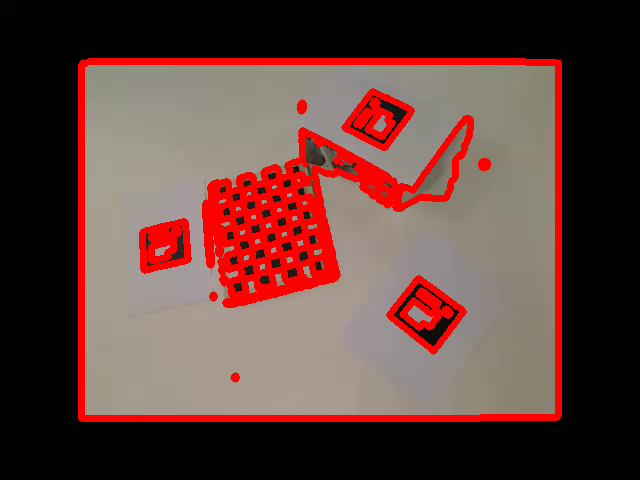

<img src="https://homepages.dcc.ufmg.br/~artur.gaspar/ICV/TP2/cnts1.png" alt="Drawing" style="width: 200px;"/>

Note que muitos contornos não são quadriláteros, são muito grandes ou muito pequenos, portanto não podem ser válidos. Então, filtraremos os contornos que são quadriláteros com cv2.approxPolyDP, que a área é no mínimo 1000 pixels (valor valido pro video da entrada):

In [ ]:
def area_rect_pixels(coords):
    assert(len(coords) == 4)
    p1,p2,p3,p4 = coords
    return abs(np.cross(p2-p1,p4-p1)/2)+abs(np.cross(p2-p3,p4-p3)/2)
imagecopy = image.copy()

quadcntindexes = [] # Para mostrar depois na imagem os quadrados que são alvos

quads = []
k = -1
for cnt in cnts:
    k +=1
    approx = cv2.approxPolyDP(
        cnt, 0.02 * cv2.arcLength(cnt, True), True)

    if len(approx) == 4 and area_rect_pixels(approx[:,0]) > 1000:
        quads.append(approx[:,0])
        quadcntindexes.append(k)
        cv2.drawContours(imagecopy, [cnt], 0, (0, 0, 255), 5)
cv2.imshow("first frame - better contours",imagecopy)
cv2.imwrite("bettercnts1.png",imagecopy)
cv2.waitKey()
cv2.destroyAllWindows()

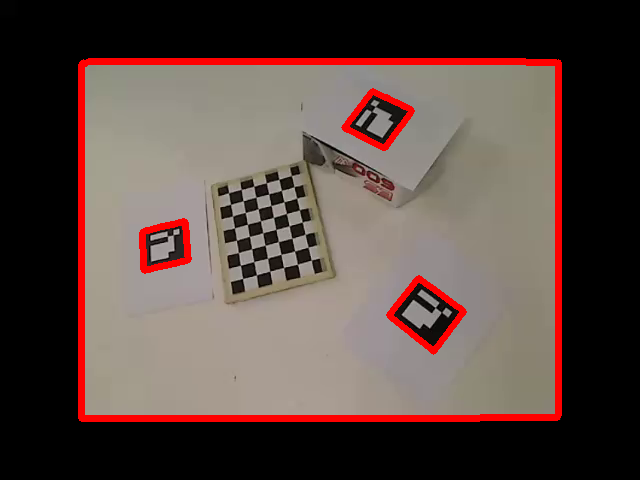

Apesar de remover muitos quadrados inválidos, isso não filtra todos os alvos como desejamos. Então, ainda falta realizar o processo de homografia e depois Template Matching. Abaixo mapeamos os alvos em suas várias orientações para imagens do mesmo tamanho do alvo.jpg, mostrando apenas os quadriláteros que obtiveram Cross-Correlation Normalizada de pelo menos 0.5 (note como j varia de 0 a 4, testando todas as orientações possíveis, e no final salvamos todos contornos com seus 4 pontos na mesma ordem relativa, que será importante na hora de renderizar as setas dos cubos):

In [ ]:
imagecopy = image#.copy() # tiramos o .copy() para continuar mostrando o contorno
retq = []
dsts = []
k = -1
for quad in quads:
    k += 1
    twid, thei = target.shape[0], target.shape[1]
    input_points = quad.tolist()
    output_points = np.array([[0,thei-1],[0,0],[twid-1,0]])
    for j in range(4):
        input_points2 = np.array(input_points[:-1]).astype(np.float32)
        output_points = output_points.astype(np.float32)

        wa = cv2.getAffineTransform(input_points2, output_points)
        dst = cv2.warpAffine(trimg,wa,(twid,thei))

        sim = ((dst-dst.mean())/dst.std()*(target-target.mean())/target.std()).mean()

        input_points = [input_points[-1]]+input_points[:-1]
        if sim >= 50/100: # normalized cross-correlation
            retq.append(np.array(input_points, dtype = np.float32))
            cv2.drawContours(imagecopy, [cnts[quadcntindexes[k]]], 0, (0, 0, 255), 5)
            dsts.append(dst)
cv2.imshow("first frame - targets",imagecopy)
cv2.imwrite("targets1.png",imagecopy)
cv2.waitKey()
cv2.destroyAllWindows()

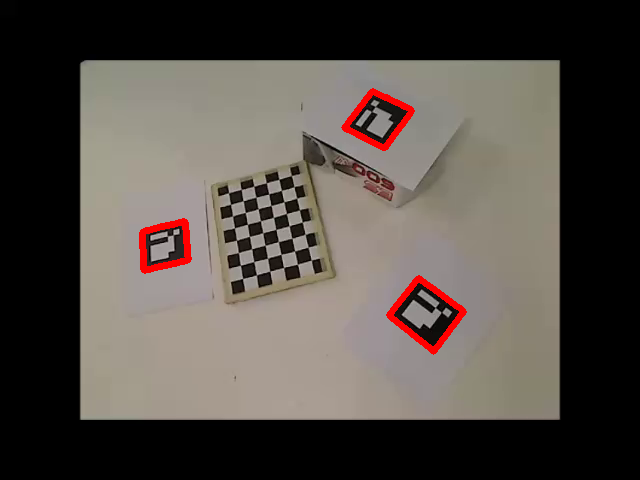

Abaixo mostramos os alvos da imagem que foram comparados com sucesso (depois de feita a homografia) com o alvo.jpg:

In [ ]:
k = -1
for dst in dsts:
    k += 1
    cv2.imshow("homography result number " + str(k),dst)
    cv2.imwrite("targets1_hom_"+str(k)+".png",dst)
    cv2.waitKey()
    cv2.destroyAllWindows()

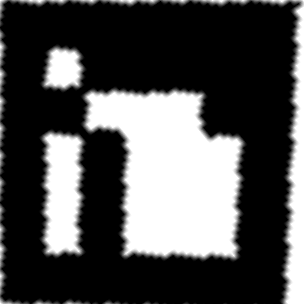

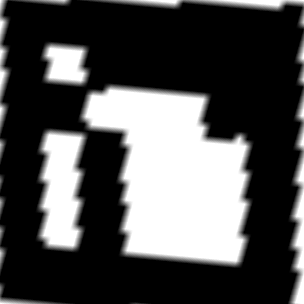

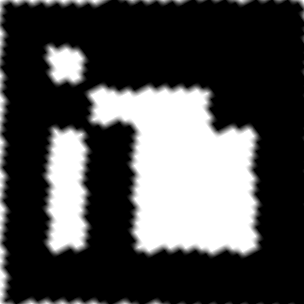

## Parte 3: Estimando parâmetros extrínsecos:

Nessa etapa nós estimamos a posição da câmera em relação a cada um dos alvos, utilizando a função do OpenCV: cv2.solvePnP():

In [ ]:
targetcoords = np.array(retq, dtype = np.float64)
obj_pts = np.array([[1,-1,0],[-1,-1,0],[-1,1,0],[1,1,0]], dtype = np.float64)

# Pra caso nao encontremos um alvo, renderizar o Pikachu correspondente fora da área de visão da câmera
rot1 = rot2 = rot3 = np.array([[0],[0],[0]], dtype = np.float64)
tra1 = tra2 = tra3 = np.array([[100],[100],[100]], dtype = np.float64)

if len(targetcoords) > 0:
    success, rot1, tra1 = cv2.solvePnP(obj_pts, targetcoords[0], cameraMatrix, distCoeffs)
    assert(success)
if len(targetcoords) > 1:
    success, rot2, tra2 = cv2.solvePnP(obj_pts, targetcoords[1], cameraMatrix, distCoeffs)
    assert(success)
if len(targetcoords) > 2:
    success, rot3, tra3 = cv2.solvePnP(obj_pts, targetcoords[2], cameraMatrix, distCoeffs)
    assert(success)

print((rot1, tra1), (rot2, tra2), (rot3, tra3))

## Parte 4 e 5: Renderizando tudo e rotacionando Pikachus:

Agora, vamos renderizar os Pikachus, os cubos e as setas que indicam a direção que o alvo aponta, com o background sendo o frame atual, usando OpenGL. Primeiro, configuramos as texturas, as matrizes de distorção e de parâmetros intrínsecos,  e criamos a função de configuração inicial do OpenGL:

- openCV_to_openGL é usada porque as coordenadas de imagem do openCV e do openGL são dadas em sistemas diferentes.
- initOpenGL é usada como no código esqueleto, para inicializar as texturas, objetos e tudo mais necessário para uso futuro no programa. Note que as texturas são todas fixas, depois só modificamos a textura do background.

In [ ]:
openCV_to_openGL = np.array(
    [
        [1, 0, 0,0],
        [0,-1, 0,0],
        [0, 0,-1,0],
        [0, 0, 0,1]
    ]
    , dtype = np.float64
)
rotval = 0

background_texture = None
pikapika1 = None
pikapika2 = None
pikapika3 = None
width, height = 640, 480

surf = pygame.surfarray.make_surface(image)
imagepygame = pygame.image.tostring(surf, 'RGBA', 1)

def initOpenGL():
    global background_texture
    global imagepygame
    global pikapika1
    global pikapika2
    global pikapika3
    global width, height
    glClearColor(0.0, 0.0, 0.0, 0.0)
    glClearDepth(1.0)

    glEnable(GL_DEPTH_TEST)

    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()

    fovy = 45
    aspect = (width)/(height)
    gluPerspective(fovy, aspect, 0.1, 100.0)


    pikapika1 = OBJ("Pikachu.obj", swapyz=True)
    pikapika2 = OBJ("Pikachu.obj", swapyz=True)
    pikapika3 = OBJ("Pikachu.obj", swapyz=True)

    background_texture = glGenTextures(1)
    glBindTexture(GL_TEXTURE_2D, background_texture)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER,
        GL_LINEAR)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER,
        GL_LINEAR)
    glTexImage2D(GL_TEXTURE_2D, 0, GL_RGBA, ix, iy, 0, GL_BGRA,
        GL_UNSIGNED_BYTE, imagepygame)

Agora a função que atualiza a imagem de fundo:

- Essa função simplesmente cria um retângulo de fundo e desenha nele o frame do vídeo, já com os contornos desenhados (será feito em outra função). Assumimos também que a profundidade foi desligada antes dessa função ser chamada, pois senão o retângulo do fundo pode acabar ficando na frente dos Pikachus, e aí não seria possível vê-los.

In [ ]:
def draw_background():
    global background_texture
    depth = 1 # profundidade
    scale = 1.13 # encontrado manualmente
    glEnable(GL_TEXTURE_2D)
    glBindTexture(GL_TEXTURE_2D, background_texture)
    glBegin(GL_POLYGON)
    glTexCoord2f(1,1)
    glVertex3f(scale*depth*-6/9,scale*depth*-0.5,-depth)
    glTexCoord2f(1,0)
    glVertex3f(scale*depth*6/9,scale*depth*-0.5,-depth)
    glTexCoord2f(0,0)
    glVertex3f(scale*depth*6/9,scale*depth*0.5,-depth)
    glTexCoord2f(0,1)
    glVertex3f(scale*depth*-6/9,scale*depth*0.5,-depth)
    glEnd()
    glDisable(GL_TEXTURE_2D)

Definimos a função que renderiza nossos objetos dados os parâmetros extrínsecos calculados pelo solvePNP, usando a matriz de visualização adequada (note que rotacionamos os Pikachus conforme o valor da variável global 'rotval', que marca quanto rodamos cada pikachu, além de algumas restrições constantes que encontramos manualmente que identificam unicamente o pikachu que gira no sentido diferente dos outros, e a restrição vale pra todo frame):

- Criamos manualmente a matriz de visualização, depois de usar cv2.Rodrigues pra calcular a matriz de rotação efetivamente.
- A seta que aponta a direção do alvo foi desenhada como um cone e um cilindro estrategicamete posicionados para parecer uma seta.
- A cada vez que um objeto é desenhado, rodamos mais um grau no valor de rotação. Isso faz com que os Pikachus rodem em graus ligeiramente distintos, mesmo se rodam no mesmo sentido.
- Foram feitas pequenas rotações e translações de ajuste pro cone, o cilindro, o cubo e o Pikachu ficarem em posições relativas entre si visualmente boas

In [ ]:
def object3D(obj, tra, rotation): # x,y,z is the world position
    global openCV_to_openGL, rotval
    rot = cv2.Rodrigues(rotation)[0]

    viewmat = np.zeros((4,4),dtype = np.float64)
    for i in range(3):
        for j in range(3):
            viewmat[i][j] = rot[i][j]
        viewmat[i][3] = tra[i][0]
    viewmat[3][3] = 1
    viewmat = viewmat.T

    viewmat = viewmat @ openCV_to_openGL

    if (tra[0] > -1.24 and tra[0] < 4.92 and tra[1] > -5.87 and tra[1] < -2.83 and tra[2] > 10.68 and tra[2] < 16.26):
        rotval *= -1

        
    glPushMatrix()
    glLoadMatrixd(viewmat)

    glDisable(GL_TEXTURE_2D)

    glRotate(-90,1,0,0)
    glColor(1/2,0,0)
    gluCylinder( gluNewQuadric() , 1/10 , 1/10 , 3 , 10 , 10)

    glTranslate(0,0,3)
    glutSolidCone(1/2,1,10,10)
    glTranslate(-0,-0,-3)

    glColor(1,1,1)
    glRotate(90,1,0,0)
    glutWireCube(3)
    glEnable(GL_TEXTURE_2D)
    # renderiza o modelo do Pikachu
    glTranslate(0,0,-1)
    glRotate(rotval,0,0,1)
    glCallList(obj.gl_list)
    glRotate(-rotval,0,0,1)
    glTranslate(0,0,1)
    glPopMatrix()
    
    if (tra[0] > -1.24 and tra[0] < 4.92 and tra[1] > -5.87 and tra[1] < -2.83 and tra[2] > 10.68 and tra[2] < 16.26):
        rotval *= -1
    rotval+=1

E definimos a função de callback do OpenGL, que desenha o fundo, os cubos, os Pikachu e as setas:

- update_image é a função, mostrada a seguir, responsável por atualizar a textura do fundo e calcular os parâmetros extrínsecos da câmera em relação a cada alvo.
- Como dito anteriormente, é preciso desativar a profundidade para desenhar o fundo.

In [ ]:
def displayCallback():
    global pikapika1
    global pikapika2
    global pikapika3
    global tra1lim, tra2lim, tra3lim, framem

    glMatrixMode(GL_MODELVIEW)
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    glLoadIdentity()
    
    # Atualizar imagem
    (rot1, tra1), (rot2, tra2), (rot3, tra3) = update_image()
    # Desenhar fundo
    glDepthMask(GL_FALSE)
    draw_background()
    glFlush()
    glDepthMask(GL_TRUE)

    # Desenhar objetos 3D:
    object3D(pikapika1,tra1,rot1)
    object3D(pikapika1,tra2,rot2) 
    object3D(pikapika1,tra3,rot3) 

    # Mostrar na tela
    glutSwapBuffers()    

E a função de idleCallback() do OpenGL (idêntica ao do código esqueleto):

In [ ]:
def idleCallback():

    glutPostRedisplay()

Precisamos também definir a função que atualiza o background de acordo com o frame do video:

- Lemos mais um frame do vídeo. Caso o vídeo tenha acabado, resetamos o leitor de vídeo e começamos novamente pelo primeiro frame.
- Encontramos os alvos usando as funções find_good_quadrilaterals e quadcntindexes, mostradas a seguir.
- Utilizamos solvePNP, como descrito anteriormente, para computar os parâmetros extrínsecos da câmera em relação a cada alvo.
- Atualizamos a textura já existente e retornamos os parâmetros extrínsecos. Para fins de simplicidade, se não encontramos um Pikachu, desenhamos ele fora do campo de visão da câmera (100 de translação em cada eixo).

In [ ]:
def update_image():
    global background_texture
    global vidcap
    global image
    global imagepygame
    global cameraMatrix
    global distCoeffs
    success,image = vidcap.read()
    if not success:
        vidcap = cv2.VideoCapture('entrada.mp4')
        success,image = vidcap.read()
    assert(success)
    assert(image.max() <= 255 and image.min() >= 0)
    image, quads, cnts, quadcntindexes = find_good_quadrilaterals(image)
    where_pikachus  = get_targets(quads, cnts, quadcntindexes)
    where_pikachus = np.array(where_pikachus, dtype = np.float64)
    obj_pts = np.array([[1,-1,0],[-1,-1,0],[-1,1,0],[1,1,0]], dtype = np.float64)

    rot1 = rot2 = rot3 = np.array([[0],[0],[0]], dtype = np.float64)
    tra1 = tra2 = tra3 = np.array([[100],[100],[100]], dtype = np.float64)

    if len(where_pikachus) > 0:
        success, rot1, tra1 = cv2.solvePnP(obj_pts, where_pikachus[0], cameraMatrix, distCoeffs)
        assert(success)
    if len(where_pikachus) > 1:
        success, rot2, tra2 = cv2.solvePnP(obj_pts, where_pikachus[1], cameraMatrix, distCoeffs)
        assert(success)
    if len(where_pikachus) > 2:
        success, rot3, tra3 = cv2.solvePnP(obj_pts, where_pikachus[2], cameraMatrix, distCoeffs)
        assert(success)

    surf = pygame.surfarray.make_surface(image)
    imagepygame = pygame.image.tostring(surf, 'RGBA', 1)
    ix, iy = surf.get_rect().size
    glBindTexture(GL_TEXTURE_2D, background_texture)
    glTexSubImage2D(GL_TEXTURE_2D, 0, 0,0, ix, iy, GL_BGRA,
        GL_UNSIGNED_BYTE, imagepygame)
    return (rot1, tra1), (rot2, tra2), (rot3, tra3)

A função que encontra os quadriláteros válidos e a que filtra os targets, já com a ordem adequada para renderizar depois:

- O funcionamento de find_good_quadrilaterals já foi explicado anteriormente nesse notebook. Mas em resumo, encontramos os contornos a partir da imagem em preto-e-branco, depois filtramos apenas os contornos que representam quadriláteros de área pelo menos 1000 pixels (pois reduz o processamento posterior e 1000 é uma constante muito boa para o vídeo de entrada).
- O funcionamento de get_targets também já foi explicado. Mas em resumo, famos a homografia com cada quadrilátero em várias orientações, e caso alguma orientação resulte numa alta correlação cruzada com o alvo original, então salvamos os pontos desse quadrado na lista de retorno, já na ordem adequada para renderizar (e isso foi descoberto manualmente, com tentativa e erro):

In [ ]:
def find_good_quadrilaterals(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, tr = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    cnts, _ = cv2.findContours(tr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    quads = []

    quadcntindexes = [] # Para mostrar depois na imagem os quadrados que são alvos

    k = -1
    for cnt in cnts:
        k += 1
        approx = cv2.approxPolyDP(
            cnt, 0.02 * cv2.arcLength(cnt, True), True)
    
        if len(approx) == 4 and approx[0][0][0] != 0 and area_rect_pixels(approx[:,0]) > 1000:
            quads.append(approx[:,0])
            quadcntindexes.append(k)
    return image, quads, cnts, quadcntindexes
def get_targets(quads, cnts, quadcntindexes):
    global target
    global image

    grayimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, trimg = cv2.threshold(grayimg, 127, 255, cv2.THRESH_BINARY)

    retq = []
    k = -1
    for quad in quads:
        k += 1
        twid, thei = target.shape[0], target.shape[1]
        input_points = quad.tolist()
        output_points = np.array([[0,thei-1],[0,0],[twid-1,0]])
        for j in range(4):
            input_points2 = np.array(input_points[:-1]).astype(np.float32)
            output_points = output_points.astype(np.float32)

            wa = cv2.getAffineTransform(input_points2, output_points)
            dst = cv2.warpAffine(trimg,wa,(twid,thei))

            sim = ((dst-dst.mean())/dst.std()*(target-target.mean())/target.std()).mean()

            input_points = [input_points[-1]]+input_points[:-1]
            if sim >= 50/100: # normalized cross-correlation
                retq.append(np.array(input_points, dtype = np.float32))
                cv2.drawContours(image, [cnts[quadcntindexes[k]]], 0, (0, 0, 255), 5)
                break
    return retq


Agora basta dar início à renderização:

- Como no código esqueleto, criamos uma janela, e chamamos o loop do openGL!
- Pra fechar essa janela, basta clicar no "X". Ela fica rodando em loop.
- Depois de fechar, é preciso reiniciar o Kernel do notebook pra visualizar o resultado de novo.

In [ ]:
dimensions = (640, 480)
glutInit()
glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE)
glutSetOption(GLUT_ACTION_ON_WINDOW_CLOSE, GLUT_ACTION_CONTINUE_EXECUTION)
glutInitWindowSize(*dimensions)
window = glutCreateWindow(b'Realidade Aumentada: Pikachu')

initOpenGL()

glutDisplayFunc(displayCallback)
glutIdleFunc(idleCallback)

glutMainLoop()